In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re

In [2]:
def read_csv(path: str):
    """
    Funcao responsavel por realizar a leitura de um dataset em formato csv

    Parameters:
    path: Arquivo csv contendo os dados

    Returns: 
    df: DataFrame contendo os dados já lidos 
    """
    df = pd.read_csv(path, low_memory=False)

    return df

In [3]:
def normalize_name(name: str)->str:
    if pd.isna(name):  # trata valores nulos
        return name
    
    # 1. Remove acentos
    name = unicodedata.normalize('NFD', name)
    name = ''.join(c for c in name if unicodedata.category(c) != 'Mn')

    # 2. Coloca em maiúsculas
    name = name.upper().strip()

    # 3. Padronizações específicas
    if "JUNTOS POR EL CAMBIO" in name:
        return "JUNTOS POR EL CAMBIO"
    elif "HACEMOS" in name:
        return "HACEMOS"
    elif "FRENTE DE IZQUIERDA Y DE TRABAJADORES" in name:
        return "FRENTE DE IZQUIERDA Y DE TRABAJADORES"
    
    # 4. Limpeza final
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

In [4]:
def plot_votos(df: pd.DataFrame, cargo:str):
    """
    Plota um gráfico de barras com os votos agrupados por partido para um determinado cargo.

    Parameters:
    df: DataFrame contendo os dados
    cargo: Cargo a ser utilizado como filtro (string)
    """

    # Filtrando para apenas Presidente
    df_presidente = df[df["cargo_nombre"] == cargo]

    # Agrupando votos para Presidente por Partido
    votos_por_partido = (df_presidente.groupby("agrupacion_nombre")["votos_cantidad"].sum().sort_values(ascending=False))

    # Exibição do gráfico
    plt.figure(figsize=(10,6))
    votos_por_partido.plot(kind="bar")
    plt.title(f"Votos para {cargo} por Partido")
    plt.ylabel("Quantidade de votos")
    plt.xlabel("Partido", fontsize=8)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [5]:
#Leitura do CSV de 2023 contendo os resultados eleitorais provisorios
df_2023 = read_csv("data\ResultadoElectorales_2023_Generales.csv")
df_2023["agrupacion_nombre"] = df_2023["agrupacion_nombre"].apply(normalize_name)

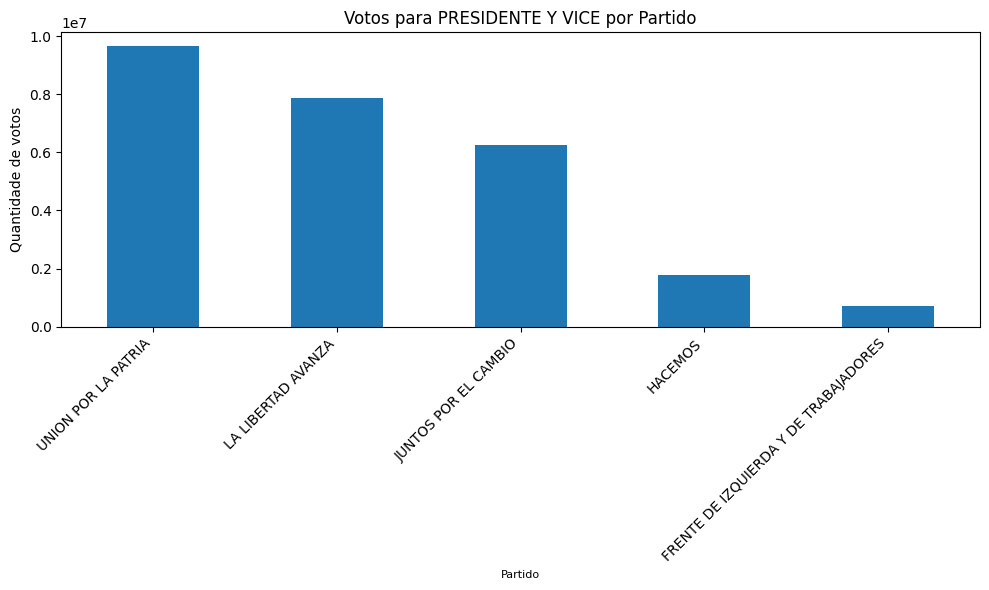

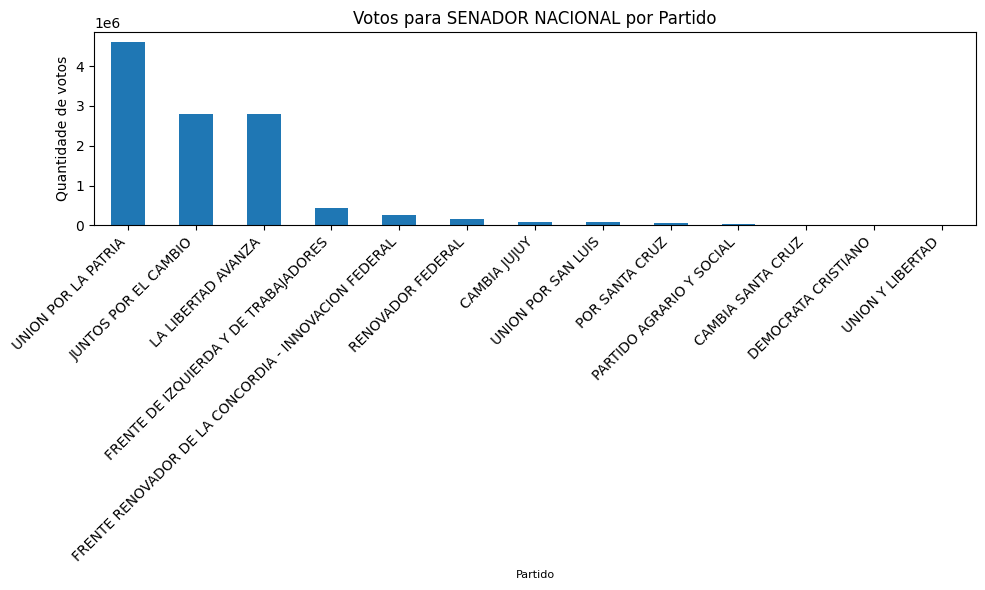

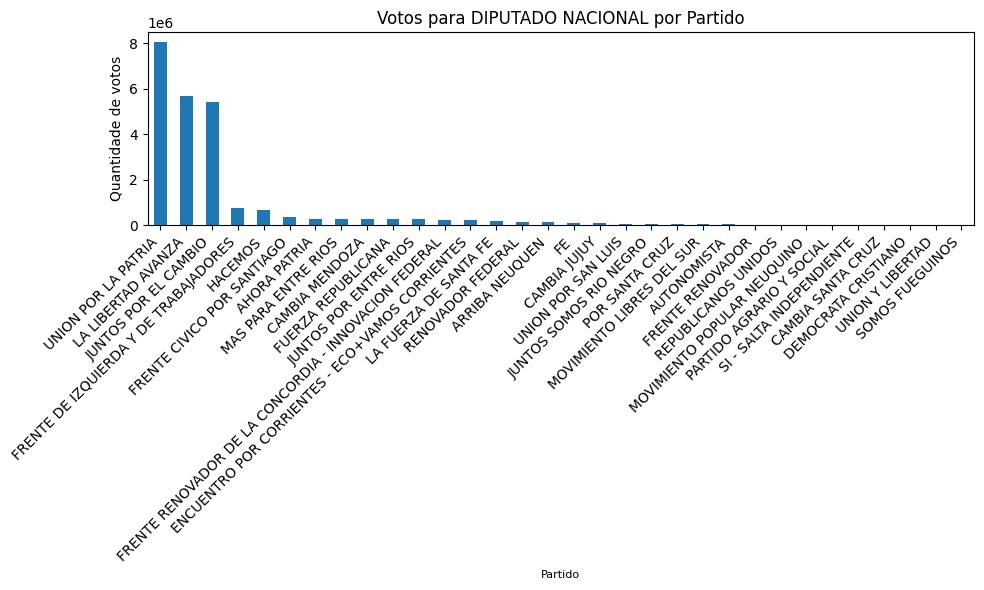

In [6]:
plot_votos(df_2023,"PRESIDENTE Y VICE")
plot_votos(df_2023,"SENADOR NACIONAL")
plot_votos(df_2023,"DIPUTADO NACIONAL")

In [7]:
#Leitura do CSV de 2021 contendo os resultados eleitorais provisorios
df_2021 = read_csv("data\ResultadosElectorales_2021_Generales.csv")
df_2021["agrupacion_nombre"] = df_2021["agrupacion_nombre"].apply(normalize_name)

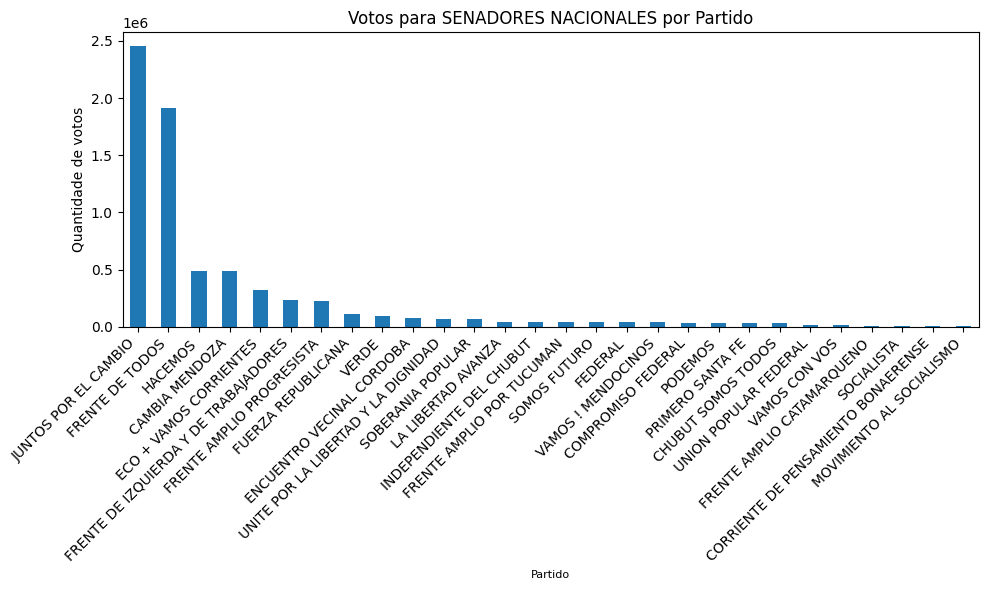

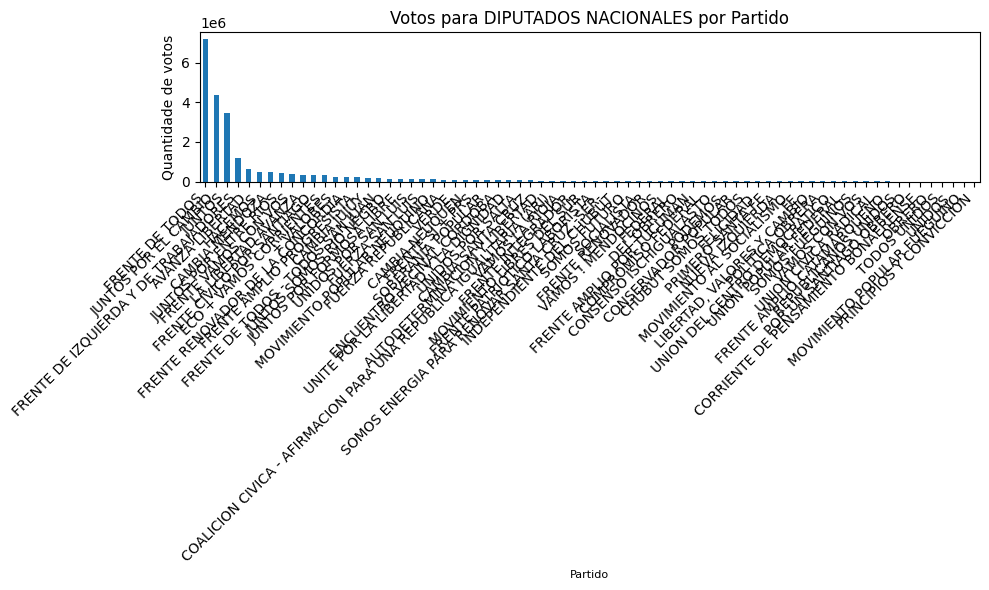

In [8]:
plot_votos(df_2021,"SENADORES NACIONALES")
plot_votos(df_2021,"DIPUTADOS NACIONALES")

In [9]:
#Leitura do CSV de 2019 contendo os resultados eleitorais provisorios
df_2019 = read_csv("data\ResultadosElectorales_2019_Generales.csv")
df_2019['agrupacion_nombre'] = df_2019['agrupacion_nombre'].apply(normalize_name)

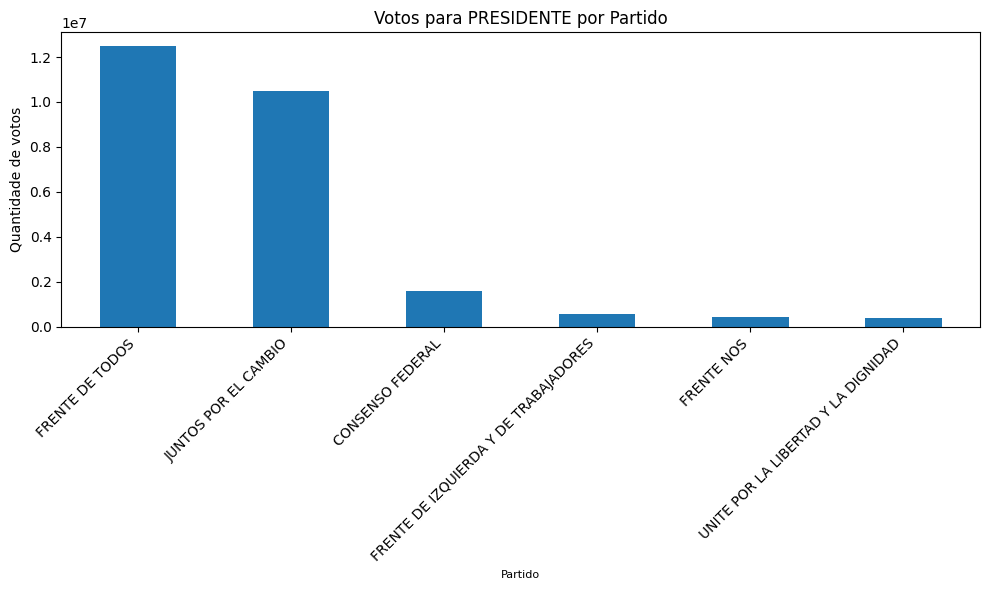

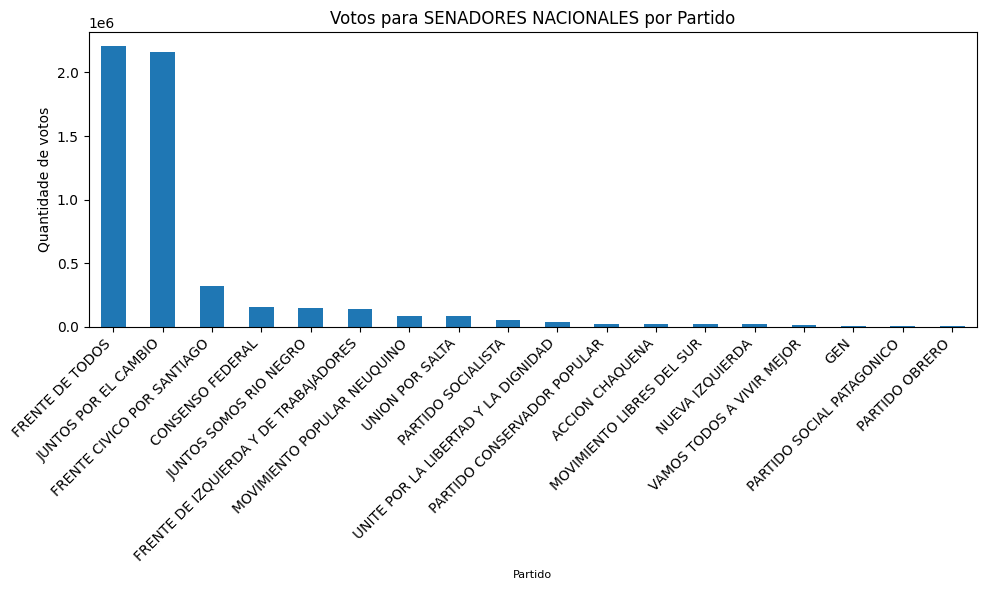

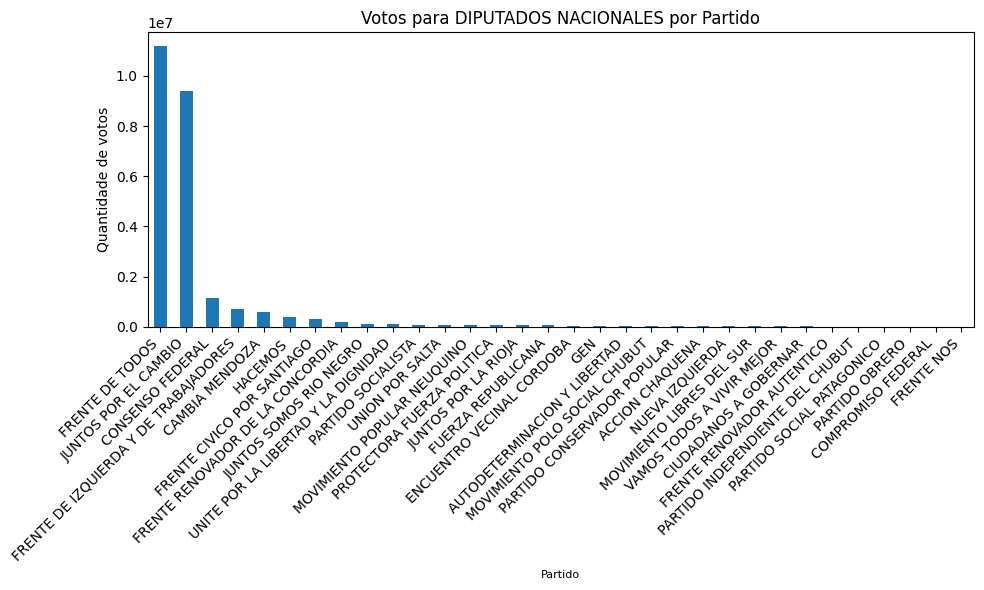

In [10]:
plot_votos(df_2019,"PRESIDENTE")
plot_votos(df_2019,"SENADORES NACIONALES")
plot_votos(df_2019,"DIPUTADOS NACIONALES")

In [11]:
df_ipp = read_csv("data\PartidosNacionaisArgentinaIPP.csv")
df_ipp['Partidos/Coalizacoes Nacionais'] = df_ipp['Partidos/Coalizacoes Nacionais'].apply(normalize_name)

In [12]:
def calcular_ipp_eleicao(df_votos: pd.DataFrame, df_ipp: pd.DataFrame, filtro_cargo: str ,coluna_partido="agrupacion_nombre"):
    # Filtra apenas a eleicao e o cargo desejado
    df_cargo = df_votos[df_votos["cargo_nombre"] == filtro_cargo].copy()

    # Merge para associar o IPP de cada partido
    df_merge = df_cargo.merge(df_ipp, left_on=coluna_partido, right_on="Partidos/Coalizacoes Nacionais", how='left')

    # Renomeia a col IPP
    df_merge.rename(columns={"IPP (Índice de Posição Política)": "IPP"}, inplace=True)
    
    # Calcula peso IPP * votos
    df_merge["IPP_ponderado"] = df_merge["IPP"] * df_merge["votos_cantidad"]

    # Soma todos os IPPs ponderados
    ipp_total = df_merge["IPP_ponderado"].sum()

    return ipp_total, df_merge

In [13]:
ipp_total_2023_deputados, df_merge_2023_deputados = calcular_ipp_eleicao(df_2023, df_ipp, "DIPUTADO NACIONAL")
print("IPP total da eleição:", ipp_total_2023_deputados)

IPP total da eleição: 7815621.0


In [14]:
ipp_total_2021_deputados, df_merge_2021_deputados = calcular_ipp_eleicao(df_2021, df_ipp, "DIPUTADOS NACIONALES")
print("IPP total da eleição:", ipp_total_2021_deputados)

IPP total da eleição: -4057696.0


In [15]:
ipp_total_2019_deputados, df_merge_2019_deputados = calcular_ipp_eleicao(df_2019, df_ipp, "DIPUTADOS NACIONALES")
print("IPP total da eleição:", ipp_total_2019_deputados)

IPP total da eleição: -2891187.0


In [16]:
partidos_2019_deputados_nacionais = set(df_merge_2019_deputados["agrupacion_nombre"].dropna().unique())
partidos_2021_deputados_nacionais = set(df_merge_2021_deputados["agrupacion_nombre"].dropna().unique())
partidos_2023_deputados_nacionais = set(df_merge_2023_deputados["agrupacion_nombre"].dropna().unique())

partidos_ja_classificados = set(df_ipp["Partidos/Coalizacoes Nacionais"].dropna().unique())

partidos_nao_classificados_2019 = partidos_2019_deputados_nacionais - partidos_ja_classificados
partidos_nao_classificados_2021 = partidos_2021_deputados_nacionais - partidos_ja_classificados
partidos_nao_classificados_2023 = partidos_2023_deputados_nacionais - partidos_ja_classificados

print("Partidos de 2019 para deputados nacionais ainda nao classificados:")
print(partidos_nao_classificados_2019)
print(len(partidos_nao_classificados_2019))

print("Partidos de 2021 para deputados nacionais ainda nao classificados:")
print(partidos_nao_classificados_2021)
print(len(partidos_nao_classificados_2021))

print("Partidos de 2023 para deputados nacionais ainda nao classificados:")
print(partidos_nao_classificados_2023)
print(len(partidos_nao_classificados_2023))

Partidos de 2019 para deputados nacionais ainda nao classificados:
{'MOVIMIENTO POLO SOCIAL CHUBUT', 'FRENTE RENOVADOR AUTENTICO', 'FRENTE RENOVADOR DE LA CONCORDIA', 'UNITE POR LA LIBERTAD Y LA DIGNIDAD', 'CAMBIA MENDOZA', 'VAMOS TODOS A VIVIR MEJOR', 'FUERZA REPUBLICANA', 'MOVIMIENTO POPULAR NEUQUINO', 'CIUDADANOS A GOBERNAR', 'JUNTOS POR LA RIOJA', 'UNION POR SALTA', 'CONSENSO FEDERAL', 'FRENTE NOS', 'JUNTOS SOMOS RIO NEGRO', 'ACCION CHAQUENA', 'PROTECTORA FUERZA POLITICA', 'PARTIDO INDEPENDIENTE DEL CHUBUT', 'FRENTE CIVICO POR SANTIAGO', 'PARTIDO SOCIAL PATAGONICO', 'ENCUENTRO VECINAL CORDOBA', 'AUTODETERMINACION Y LIBERTAD'}
21
Partidos de 2021 para deputados nacionais ainda nao classificados:
{'FRENTE INTEGRADOR', 'FRENTE PATRIOTICO LABORISTA', 'JUNTOS POR ENTRE RIOS', 'REPUBLICANOS UNIDOS', 'FRENTE RENOVADOR DE LA CONCORDIA', 'UNITE POR LA LIBERTAD Y LA DIGNIDAD', 'SOMOS FUTURO', 'CAMBIA MENDOZA', 'FRENTE DE TODOS - TODOS SAN JUAN', 'FUERZA REPUBLICANA', 'CHUBUT SOMOS TODOS', 'M